In [1]:
import ray

In [2]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-02-27 11:51:43,947	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.8.0


In [3]:
ray.cluster_resources()

{'CPU': 8.0,
 'node:__internal_head__': 1.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 2147483648.0,
 'memory': 7385649972.0}

In [4]:
num_workers = 4
resources_per_worker={"CPU": 1, "GPU": 0}

In [5]:
import os
import sys

In [6]:
directory_path = 'notebooks/'
parent_dir = os.path.dirname(os.path.dirname(directory_path))
sys.path.append(parent_dir)

In [7]:
import pandas as pd

In [8]:
DATASET_LOC = "../data/shot_logs.csv"

In [9]:
df = pd.read_csv(DATASET_LOC)
df.head(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,20.7,2,missed,"Jack, Jarrett",101127,6.1,0,0,brian roberts,203148
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,3.5,2,made,"Plumlee, Mason",203486,2.1,1,2,brian roberts,203148
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,24.6,3,missed,"Morris, Darius",202721,7.3,0,0,brian roberts,203148
9,21400890,"MAR 03, 2015 - CHA vs. LAL",H,W,1,1,2,11:32,17.4,0,...,22.4,3,missed,"Ellington, Wayne",201961,19.8,0,0,brian roberts,203148


In [10]:
df.SHOT_RESULT.value_counts()

missed    70164
made      57905
Name: SHOT_RESULT, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Split dataset
test_size = 0.2
train_df,  val_df = train_test_split(df, stratify=df.SHOT_RESULT, test_size=test_size, random_state=1234)

In [13]:
train_df.SHOT_RESULT.value_counts()

missed    56131
made      46324
Name: SHOT_RESULT, dtype: int64

In [14]:
val_df.SHOT_RESULT.value_counts() * int((1 - test_size) / test_size)

missed    56132
made      46324
Name: SHOT_RESULT, dtype: int64

### EDA

In [15]:
# Shots distribution
shots_dist = df.SHOT_RESULT.value_counts()

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

/var/folders/cv/j0t3w1hn3zqcllq375c3r5180000gn/T/ipykernel_9632/577576624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=shots_dist.index, y=shots_dist.values, palette=['red', 'green'])
/var/folders/cv/j0t3w1hn3zqcllq375c3r5180000gn/T/ipykernel_9632/577576624.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(shots_dist.index, rotation=0, fontsize=8)


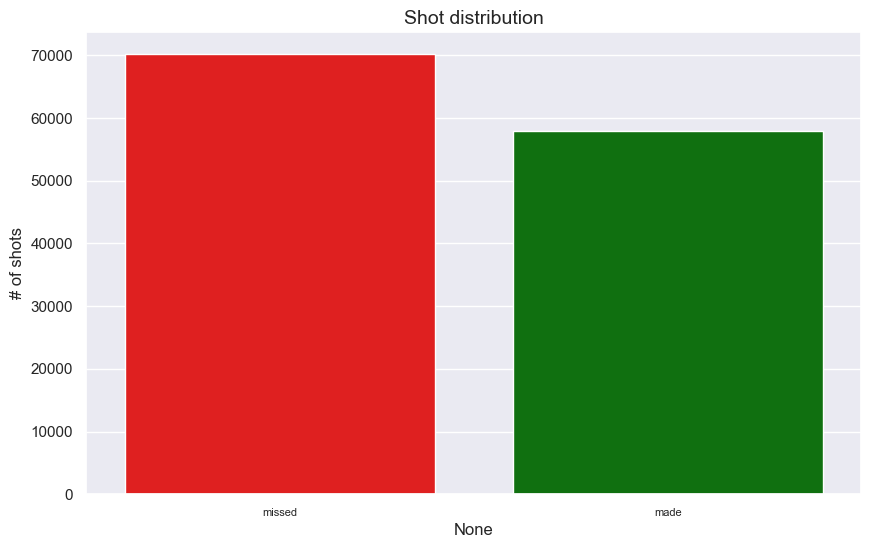

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=shots_dist.index, y=shots_dist.values, palette=['red', 'green'])
ax.set_xticklabels(shots_dist.index, rotation=0, fontsize=8)
plt.title("Shot distribution", fontsize=14)
plt.ylabel("# of shots", fontsize=12)
plt.show()

In [18]:
df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [19]:
# Feature selection
df = df[['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'SHOT_RESULT']]
df


,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,SHOT_RESULT
0,10.8,2,1.9,7.7,2,1.3,made
1,3.4,0,0.8,28.2,3,6.1,missed
2,NaN,3,2.7,10.1,2,0.9,missed
3,10.3,2,1.9,17.2,2,3.4,missed
4,10.9,2,2.7,3.7,2,1.1,missed
...,...,...,...,...,...,...,...
128064,18.3,5,6.2,8.7,2,0.8,missed
128065,19.8,4,5.2,0.6,2,0.6,made
128066,23.0,2,4.2,16.9,2,4.2,made
128067,9.1,4,4.5,18.3,2,3.0,missed


In [20]:
# Find columns with NaN values
df.isna().any()

SHOT_CLOCK         True
DRIBBLES          False
TOUCH_TIME        False
SHOT_DIST         False
PTS_TYPE          False
CLOSE_DEF_DIST    False
SHOT_RESULT       False
dtype: bool

### Preprocessing

In [21]:
# Replace NaN with 0.0
df['SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(0.0)
df

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,SHOT_RESULT
0,10.8,2,1.9,7.7,2,1.3,made
1,3.4,0,0.8,28.2,3,6.1,missed
2,0.0,3,2.7,10.1,2,0.9,missed
3,10.3,2,1.9,17.2,2,3.4,missed
4,10.9,2,2.7,3.7,2,1.1,missed
...,...,...,...,...,...,...,...
128064,18.3,5,6.2,8.7,2,0.8,missed
128065,19.8,4,5.2,0.6,2,0.6,made
128066,23.0,2,4.2,16.9,2,4.2,made
128067,9.1,4,4.5,18.3,2,3.0,missed


In [22]:
def encode_categorical(df, column_name):
    categories = df[column_name].unique().tolist()
    category_to_index = {pt_type: i for i, pt_type in enumerate(categories)}
    return category_to_index

In [23]:
# Encode PTS_TYPE and SHOT_RESULT
pts_type_to_index = encode_categorical(df, column_name='PTS_TYPE')
df['PTS_TYPE'] = df['PTS_TYPE'].map(pts_type_to_index)
shot_result_to_index = encode_categorical(df, column_name='SHOT_RESULT')
df['SHOT_RESULT'] = df['SHOT_RESULT'].map(shot_result_to_index)
df

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,SHOT_RESULT
0,10.8,2,1.9,7.7,0,1.3,0
1,3.4,0,0.8,28.2,1,6.1,1
2,0.0,3,2.7,10.1,0,0.9,1
3,10.3,2,1.9,17.2,0,3.4,1
4,10.9,2,2.7,3.7,0,1.1,1
...,...,...,...,...,...,...,...
128064,18.3,5,6.2,8.7,0,0.8,1
128065,19.8,4,5.2,0.6,0,0.6,0
128066,23.0,2,4.2,16.9,0,4.2,0
128067,9.1,4,4.5,18.3,0,3.0,1


In [24]:
pts_type_to_index

{2: 0, 3: 1}

In [25]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [26]:
index_to_class = {v:k for k, v in pts_type_to_index.items()}
decode(df.head()['PTS_TYPE'].values, index_to_class=index_to_class)

[2, 3, 2, 2, 2]

In [27]:
def preprocess(df):
    """Preprocess the data"""
    df = df[['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'SHOT_RESULT']]
    df.loc[:, 'SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(0.0)
    pts_type_to_index = encode_categorical(df, column_name='PTS_TYPE')
    df.loc[:, 'PTS_TYPE'] = df['PTS_TYPE'].map(pts_type_to_index)
    shot_result_to_index = encode_categorical(df, column_name='SHOT_RESULT')
    df.loc[:, 'SHOT_RESULT'] = df['SHOT_RESULT'].map(shot_result_to_index)
    X = df.drop(columns='SHOT_RESULT').values
    y = df['SHOT_RESULT'].values
    return X, y


In [28]:
X_train, y_train = preprocess(train_df)
X_val, y_val = preprocess(val_df)

/var/folders/cv/j0t3w1hn3zqcllq375c3r5180000gn/T/ipykernel_9632/248475991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(0.0)
/var/folders/cv/j0t3w1hn3zqcllq375c3r5180000gn/T/ipykernel_9632/248475991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'PTS_TYPE'] = df['PTS_TYPE'].map(pts_type_to_index)
/var/folders/cv/j0t3w1hn3zqcllq375c3r5180000gn/T/ipykernel_9632/248475991.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy 

### Training with Ray

### Experimentation with Mlflow

In [29]:
import mlflow
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the experiment name
mlflow.set_experiment('hyperparameter-tuning')

# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(1, 9)),
    'min_child_weight': hp.choice('min_child_weight', range(0, 10)),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01]),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'gamma': hp.uniform('gamma', 0, 5),
}

# Define the objective function
def objective(params):
    with mlflow.start_run():

        # Train model
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)

        # Evaluate model
        predictions = model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        precision = precision_score(y_val, predictions)
        recall = recall_score(y_val, predictions)
        f1 = f1_score(y_val, predictions)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1_score', f1)
        mlflow.xgboost.log_model(model, 'model')

        return {'loss': -f1, 'status': STATUS_OK}

# Perform optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:02<00:49,  2.58s/trial, best loss: -0.2120130835563485]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:04<00:42,  2.34s/trial, best loss: -0.2120130835563485]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 15%|█▌        | 3/20 [00:06<00:38,  2.26s/trial, best loss: -0.2120130835563485]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 20%|██        | 4/20 [00:08<00:34,  2.13s/trial, best loss: -0.2120130835563485]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 25%|██▌       | 5/20 [00:10<00:29,  1.97s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 30%|███       | 6/20 [00:12<00:28,  2.02s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

 35%|███▌      | 7/20 [00:14<00:26,  2.06s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 40%|████      | 8/20 [00:16<00:22,  1.90s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 45%|████▌     | 9/20 [00:18<00:21,  1.98s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

 50%|█████     | 10/20 [00:20<00:18,  1.84s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 55%|█████▌    | 11/20 [00:21<00:16,  1.88s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

 60%|██████    | 12/20 [00:23<00:13,  1.71s/trial, best loss: -0.21978345010043604]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 65%|██████▌   | 13/20 [00:25<00:12,  1.72s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 70%|███████   | 14/20 [00:26<00:09,  1.61s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 75%|███████▌  | 15/20 [00:27<00:07,  1.52s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

 80%|████████  | 16/20 [00:29<00:05,  1.47s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:17] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 85%|████████▌ | 17/20 [00:31<00:05,  1.73s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

 90%|█████████ | 18/20 [00:33<00:03,  1.78s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

 95%|█████████▌| 19/20 [00:35<00:02,  2.02s/trial, best loss: -0.25075757575757573]

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Mode

100%|██████████| 20/20 [00:37<00:00,  1.87s/trial, best loss: -0.25075757575757573]


/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/miniconda3/envs/basketball_analytics/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



In [33]:
!mlflow ui

[2024-02-27 11:53:55 +0200] [9779] [INFO] Starting gunicorn 21.2.0
[2024-02-27 11:53:55 +0200] [9779] [INFO] Listening at: http://127.0.0.1:5000 (9779)
[2024-02-27 11:53:55 +0200] [9779] [INFO] Using worker: sync
[2024-02-27 11:53:55 +0200] [9780] [INFO] Booting worker with pid: 9780
[2024-02-27 11:53:55 +0200] [9781] [INFO] Booting worker with pid: 9781
[2024-02-27 11:53:56 +0200] [9782] [INFO] Booting worker with pid: 9782
[2024-02-27 11:53:56 +0200] [9783] [INFO] Booting worker with pid: 9783
^C
[2024-02-27 11:54:08 +0200] [9779] [INFO] Handling signal: int
[2024-02-27 11:54:09 +0200] [9783] [INFO] Worker exiting (pid: 9783)
[2024-02-27 11:54:09 +0200] [9782] [INFO] Worker exiting (pid: 9782)
[2024-02-27 11:54:09 +0200] [9781] [INFO] Worker exiting (pid: 9781)
[2024-02-27 11:54:09 +0200] [9780] [INFO] Worker exiting (pid: 9780)


In [32]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=['hyperparameter-tuning'], order_by=["metrics.f1_score DESC"])
sorted_runs.iloc[0]

run_id                                            d99b2b5efbfe40aba20b16d091e8ec55
experiment_id                                                   194799576789254176
status                                                                    FINISHED
artifact_uri                     file:///Users/argyresketsetses/Projects/basket...
start_time                                        2024-02-27 09:52:10.187000+00:00
end_time                                          2024-02-27 09:52:11.849000+00:00
metrics.accuracy                                                          0.382213
metrics.recall                                                            0.188698
metrics.f1_score                                                          0.250758
metrics.precision                                                         0.373642
metrics.f1 score                                                               NaN
params.min_child_weight                                                          5
para